## Training the ConvVAE on MNIST dataset

In [1]:
import os 
import numpy as np 

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt 
import matplotlib as mpl

import src.model as model
from src.utils import train, validate, save_reconstructed_image, create_gifs, plot_loss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = model.ConvVAE().to(device)

In [3]:
# set the learning parameters
lr = 0.001
epochs = 100
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [4]:
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

#Convert original images (28 x 28) to (32 x 32)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [5]:
#Import MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='input/',
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

val_dataset = torchvision.datasets.MNIST(root='input/',
                                           train=False,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
input_tensor, label = train_dataset[0]
print('MNIST dataset with {} train data and {} test data'.format(len(train_dataset), len(val_dataset)))
print('Type of data in dataset: {} AND {}'.format(type(input_tensor), type(label)))
print('Input tensor image dimensions: {}'.format(input_tensor.shape))

MNIST dataset with 60000 train data and 10000 test data
Type of data in dataset: <class 'torch.Tensor'> AND <class 'int'>
Input tensor image dimensions: torch.Size([1, 28, 28])


Digit label: 6


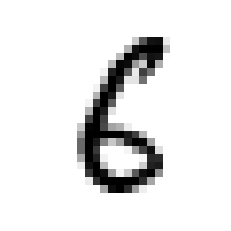

In [6]:
#Plot the data
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# look at one random sample
random_index = np.random.choice(len(train_dataset))
input_tesor, label = train_dataset[random_index]

#Visualize only the one channel -- 
plt.imshow(input_tesor[0], cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off");
print('Digit label: {}'.format(label))

torch.Size([64, 1, 28, 28]) torch.Size([64])


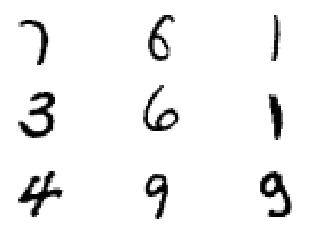

In [7]:
#Convert dataset to a dataloader class for ease of doing batching and SGD operations 
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle=True,
                          num_workers = 2)

val_loader = DataLoader(dataset = val_dataset,
                        batch_size = batch_size, 
                        num_workers = 2)

#Take a look at one batch 
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

#Plotting first 4 digits in the dataset: 
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(samples[i][0], cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off");

In [8]:
samples.shape

torch.Size([64, 1, 28, 28])

In [9]:
image_channels = 1 # MNIST dataset has grayscale digit image 
init_channels = 8 # Initial number of filters used by the ConvNet
kernel_size = 4 # Kernel size for the Conv Filter 
latent_dimensions = 16 # Dimensionality of the bottleneck layer 

enc1 = nn.Conv2d(
in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
stride=1, padding=1)

enc2 = nn.Conv2d(
in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
stride=1, padding=1)

enc3 = nn.Conv2d(
in_channels=init_channels*2, out_channels=init_channels*3, kernel_size=kernel_size, 
stride=2, padding=1)

enc4 = nn.Conv2d(
in_channels=init_channels*3, out_channels=64, kernel_size=kernel_size, 
stride=2, padding=0)

In [10]:
x = enc1(samples)
print(x.shape)
x = enc2(x)
print(x.shape)
x = enc3(x)
print(x.shape)
x = enc4(x)
print(x.shape)

torch.Size([64, 8, 27, 27])
torch.Size([64, 16, 26, 26])
torch.Size([64, 24, 13, 13])
torch.Size([64, 64, 5, 5])


In [11]:
batch, _, _, _ = x.shape

In [12]:
x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)

In [13]:
x.shape

torch.Size([64, 64])

In [ ]:
train_loss = []
val_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    train_epoch_loss = train(model, train_loader, train_dataset, device, optimizer, criterion)

    valid_epoch_loss, reconstructed_images = validate(model, val_loader, val_dataset, device, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)

    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 100


  0%|          | 0/937 [00:00<?, ?it/s]